In [14]:
# Example-1-GP-BS-Pricing
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

# Using Gaussian processes to price options

# Overview
The purpose of this notebook is to demonstrate the fitting of a Gaussian Process Regression model (GP) to option price data. In this notebook, European option prices are generated from the Black-Scholes model.  The notebook begins by building a GP call model, then a GP put model, and finally a portfolio holding which is short a put and long two calls. 

**Note that the training sample size is set to 5 in order to illustrate the uncertainty bands. Seting the training sample size to a larger value, e.g. 50, will yield a much more accurate model.**

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from BlackScholes import bsformula
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from bokeh.plotting import figure, show, output_notebook
output_notebook()

%matplotlib inline
%config Completer.use_jedi = False

Loading BokehJS ...

## Black-Scholes model parameters

In [39]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

Define functions to create the Black-Scholes option prices, which we will use to train our Gaussian processes

In [40]:
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

# GP Call pricer
Generate the training and testing data, where the input is the gridded underlying and the output are the call prices. Note that the inputs are scaled to the unit domain to aid interpretation and comparison of the hyper-parameters across different experiments.

A very small number of training points is used in order to emphasise the resulting uncertainties on the plots below.

In [63]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5  # Number of training samples
testing_number = 100 # Number of testing samples

np.random.seed(0)

train_x_1 = np.array(np.linspace(0, 1, training_number), dtype='float32').reshape(training_number, 1)
#train_x_1 = np.array([1/6, 2/6,3/6,4/6]).reshape(4, 1)
train_y_1 = [call(S) for S in train_x_1]
    
test_x_1 = np.array(np.linspace(0, 1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_1 = [call(S) for S in test_x_1]

Create a Gaussian process regression estimator with an RBF kernel, and fit it to the training data

In [67]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1, train_y_1)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [68]:
print(f"The optimal fitted kernel is an {gp.kernel_} kernel")

The optimal fitted kernel is an RBF(length_scale=0.226) kernel


Now we can get the predicted call values for the test data

In [69]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

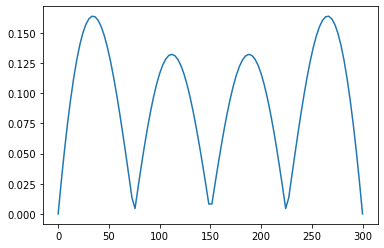

In [70]:
plt.plot(lb+(ub-lb)*test_x_1.flatten(), sigma_1)

Comparing the GP predictions to the BS model

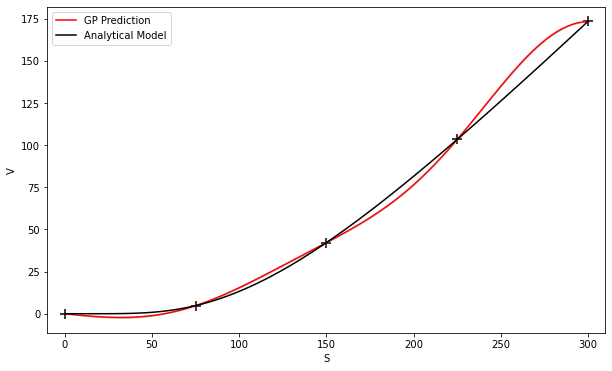

In [71]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('V');

### Using the mean of the data as the mean function

In [94]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20, normalize_y=True)
gp.fit(train_x_1, train_y_1)
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

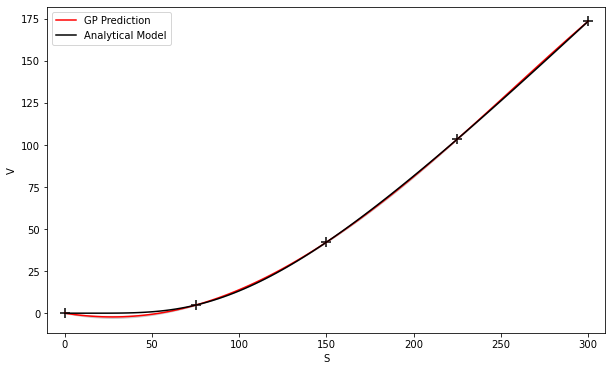

In [95]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('V');

### What about if we introduce a little noise?

In [128]:
sk_kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-08,10))
gp_noisy_normalised = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20, normalize_y=True)
gp_noisy_normalised.fit(train_x_1, train_y_1)
gp_noisy_non_normalised = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp_noisy_non_normalised.fit(train_x_1, train_y_1)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=20)

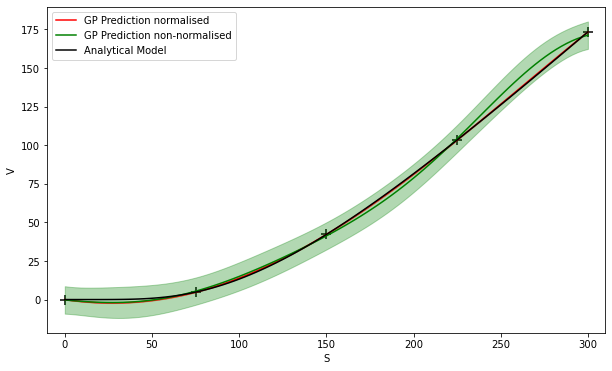

In [129]:
y_pred_1_normalised, sigma_1_normalised = gp_noisy_normalised.predict(test_x_1, return_std=True)
y_pred_1_non_normalised, sigma_1_non_normalised = gp_noisy_non_normalised.predict(test_x_1, return_std=True)

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1_normalised, color = 'red', label = 'GP Prediction normalised')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1_non_normalised, color = 'green', label = 'GP Prediction non-normalised')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 

plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1_normalised.T-2*sigma_1_normalised).flatten(), (y_pred_1_normalised.T+2*sigma_1_normalised).flatten(), color = 'red', alpha=0.3)
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1_non_normalised.T-2*sigma_1_non_normalised).flatten(), (y_pred_1_non_normalised.T+2*sigma_1_non_normalised).flatten(), color = 'green', alpha=0.3)

plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('V');

In [102]:
gp_noisy.kernel_

2**2 * RBF(length_scale=0.839) + WhiteKernel(noise_level=0.001)

### In this case normalisation helps a lot

# GP Put pricer

Now we repeat the process to create a GP modelling the value of a put. First, create the training and testing data with the Black-Scholes prices

In [118]:
train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_2 = [put(S) for S in train_x_2]
    
test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_2 = [put(S) for S in test_x_2]

Fit the GP to the training data

In [119]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20, normalize_y=True)
gp.fit(train_x_2, train_y_2)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20,
                         normalize_y=True)

And get the predicted values for the test points

In [120]:
y_pred_2, sigma_2 = gp.predict(test_x_2, return_std=True)

Comparing the GP predictions to the BS model. Note the shape of the variance bands.

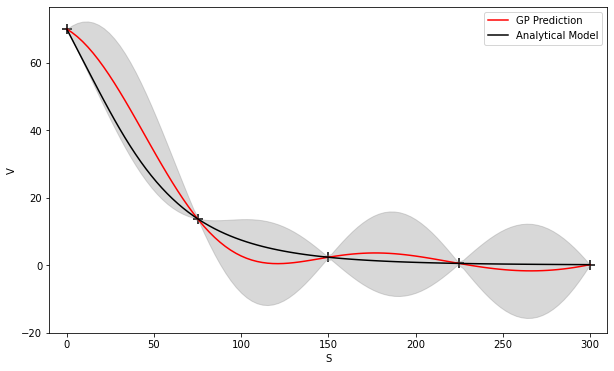

In [121]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2.T-2*sigma_2).flatten(), (y_pred_2.T+2*sigma_2).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('V');
plt.xlim([lb-10, ub+10]);

# Portfolio value

The predicted call and put values can be combined to estimate the value of a portfolio as a function of the underlying.

Here we long 2 calls and short a put:

In [122]:
# The Gaussian process' predictions
y_pred = 2 * y_pred_1 - y_pred_2
# Black-Scholes prices
test_y = 2 * np.array(test_y_1) - np.array(test_y_2)

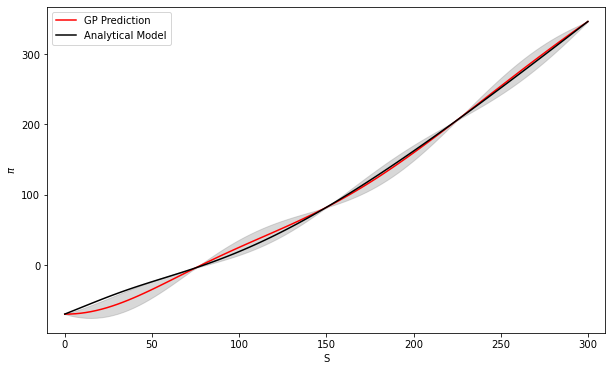

In [123]:
sigma = np.sqrt(sigma_1*sigma_1 + sigma_2*sigma_2) # Why is this the correct sigma?

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred.T-2*sigma).flatten(), (y_pred.T+2*sigma).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('$\pi$');